# American economics analysis

This notebook contains analysis of data from FRED datasets: CPIAUCSL,DFF,AHETPI,PCEPI,UNRATE.
It's goal is to show the correlations and analyze trends over the decades to see how the correlations and the indexes change.
---

## 1. Setup

#### Load dependencies and the data.

    

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import YearLocator, DateFormatter

df_all = pd.read_csv('../data/processed/dal.csv')
df_all['observation_date'] = pd.to_datetime(df_all['observation_date'])


---

## 2. Correlation Heatmap



#### We can see, that inflation indicators almost completely correlate with each other which means that the price of goods and the inflation indicator created by the government match,
#### we also see that the federal loans correlate in the opposite direction with the inflation


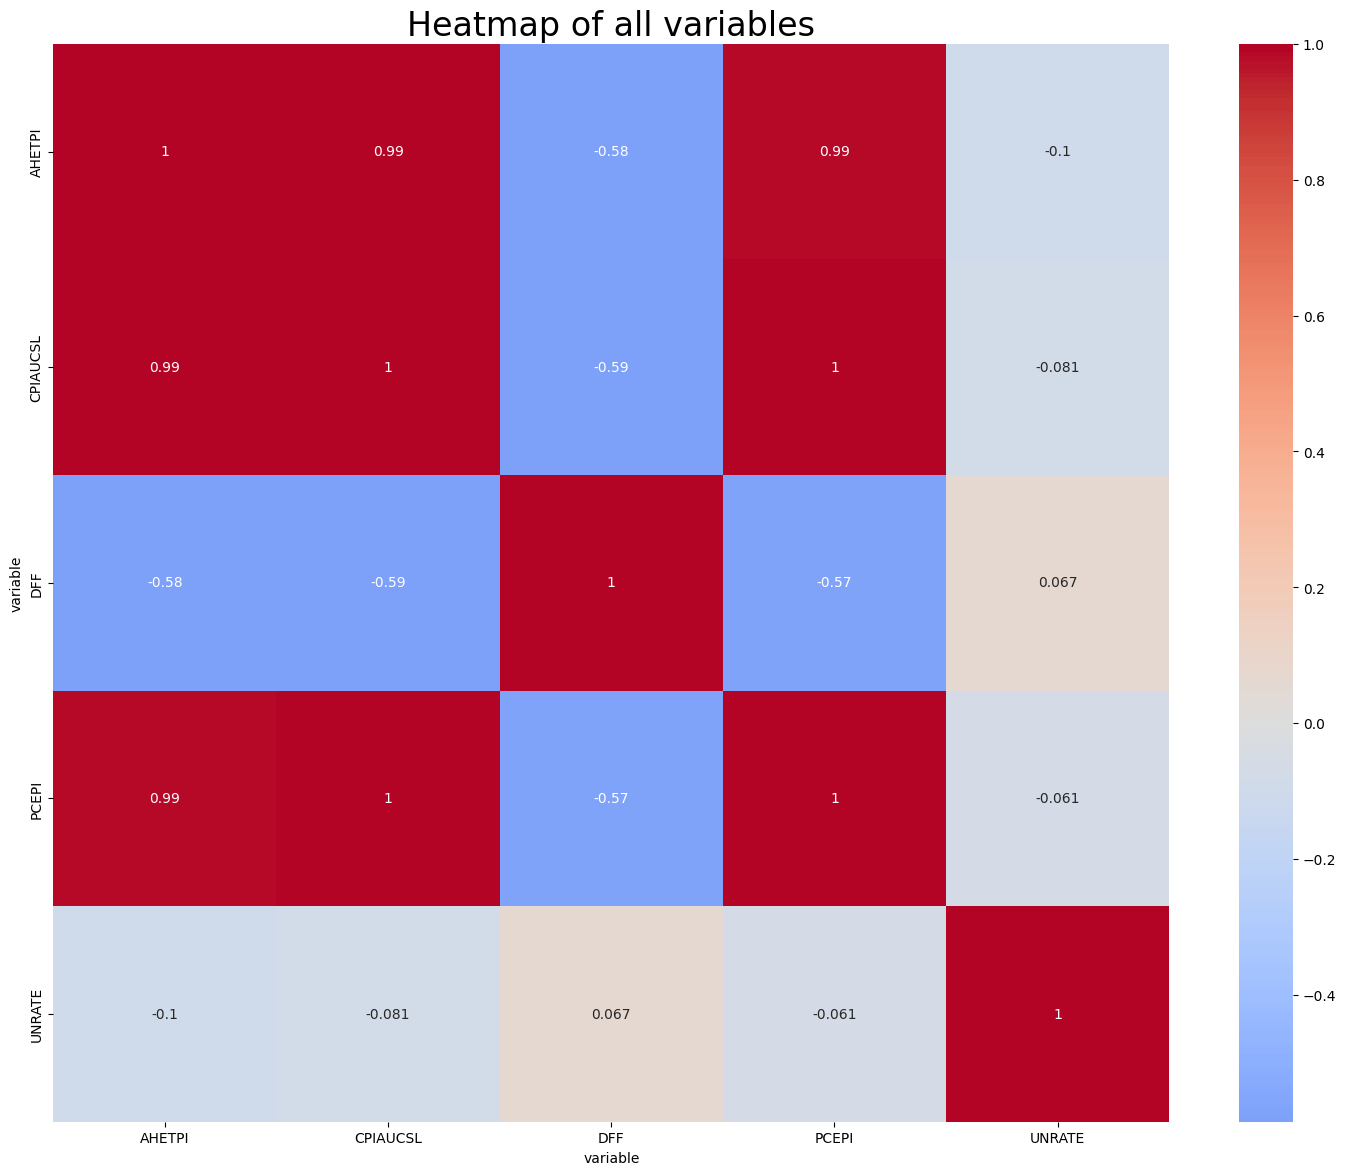

In [2]:
plt.figure(figsize=(18,14))
df_wide = df_all.pivot(index='observation_date', columns='variable', values='value')
corr = df_wide.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of all variables', fontsize=24)
plt.show()


## 3. Inflation Indicators Compared

#### Here, we can see more clearly that the inflation indicators were becoming more similar with time, until the pandemic where they split up again.


      Unnamed: 0 observation_date      value  variable
1476        1476       1964-01-01  12.700211  CPIAUCSL
1477        1477       1964-02-01  12.687897  CPIAUCSL
1478        1478       1964-03-01  12.700211  CPIAUCSL
1479        1479       1964-04-01  12.704316  CPIAUCSL
1480        1480       1964-05-01  12.716630  CPIAUCSL


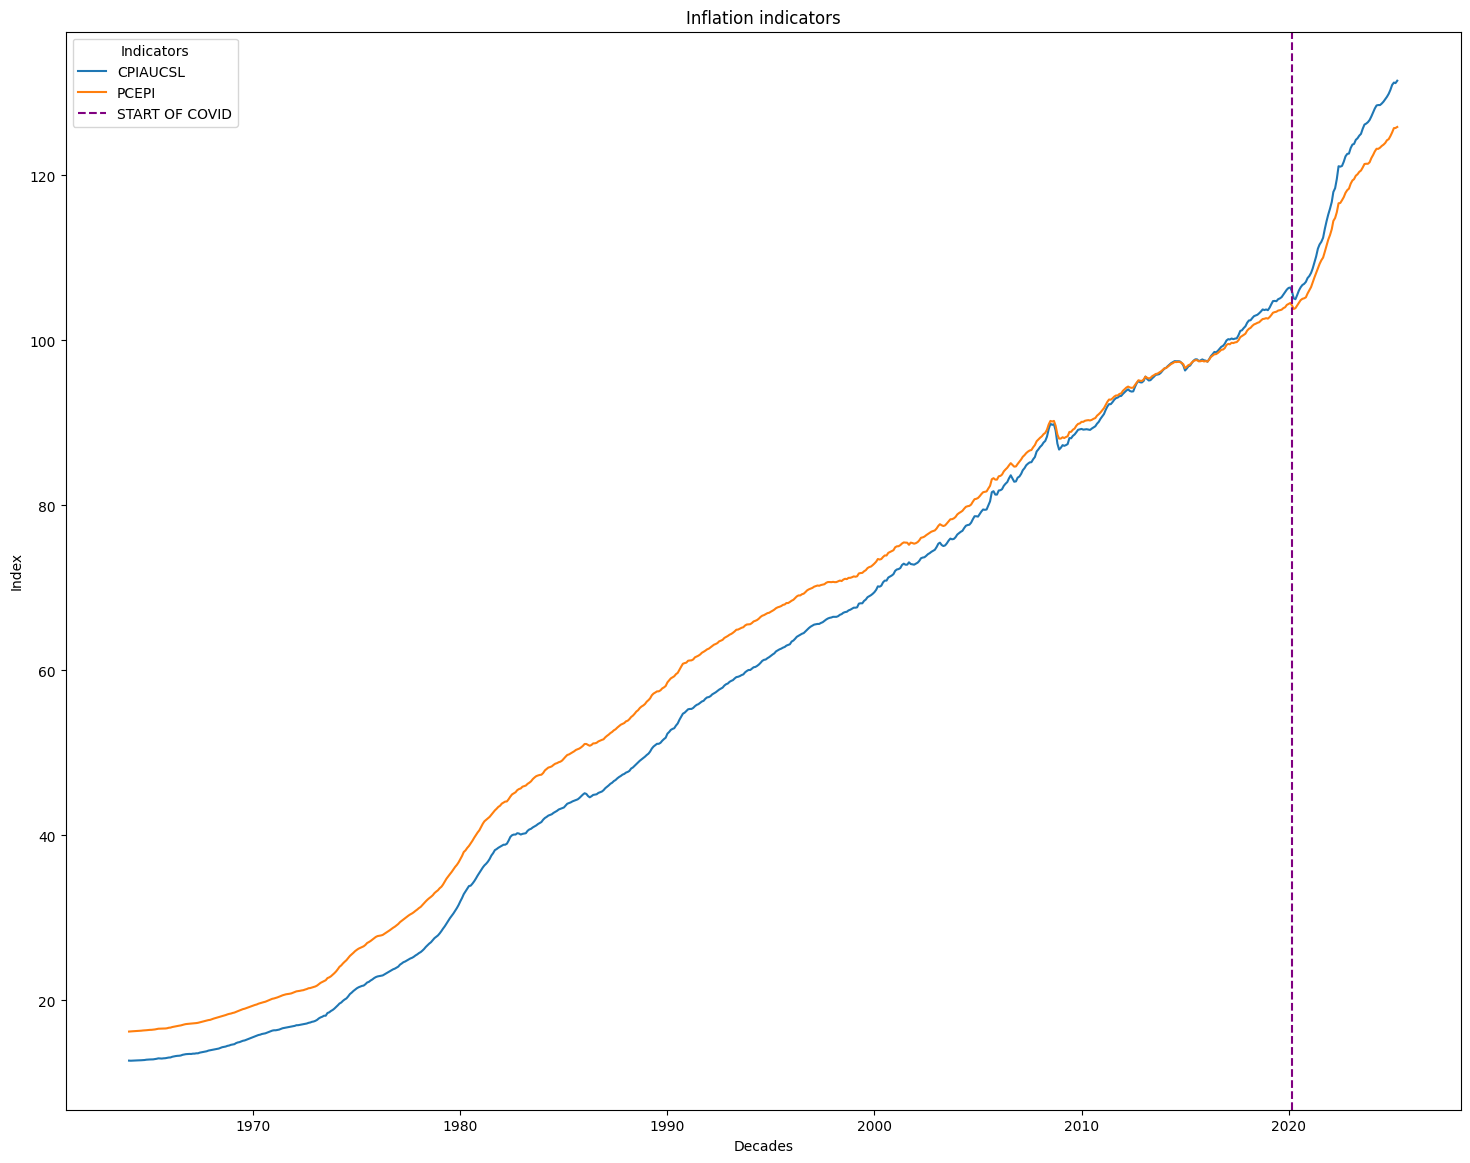

In [3]:
cpiaucsl_df = df_all[df_all['variable'] == 'CPIAUCSL']
pcepi_df = df_all[df_all['variable'] == 'PCEPI']

plt.figure(figsize=(18,14))
sns.lineplot(data=cpiaucsl_df, x='observation_date', y='value', label='CPIAUCSL')
sns.lineplot(data=pcepi_df, x='observation_date', y='value', label='PCEPI')
plt.axvline(x=pd.to_datetime('2020-03-01'),ls='--',color = 'purple',label='START OF COVID')
plt.title('Inflation indicators')
plt.xlabel('Decades')
plt.ylabel('Index')
plt.legend(title='Indicators')
plt.show()


## 4. Wages vs Inflation Lineplot

#### This plot shows how wages (AHETPI) track inflation over time, normalized to 2017. We can see that all three shoot up after the pandemic. We can also see big fluctuations during 2008 financial crisis and the start of the pandemic. 


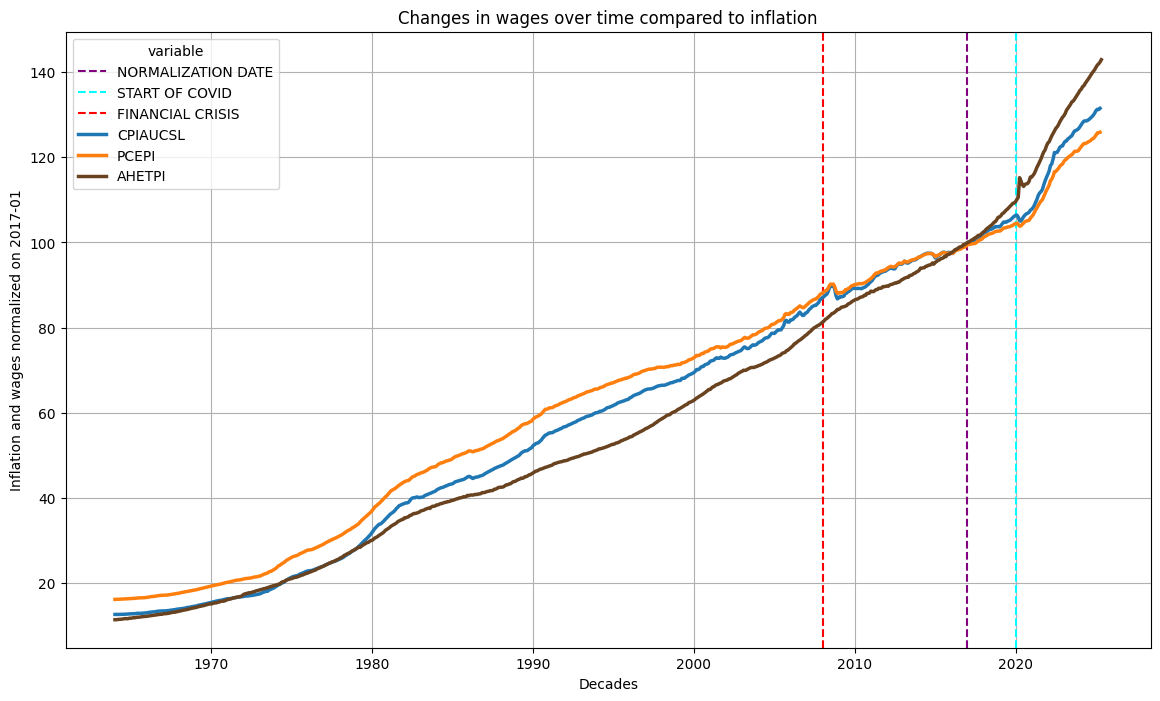

In [4]:
inflation_df = df_all[df_all['variable'].isin(['PCEPI','CPIAUCSL'])]
wages_df = df_all[df_all['variable'] == 'AHETPI'].copy()
base_year = '2017-01-01'
base_value = wages_df[wages_df['observation_date'] == base_year]
wages_df['value'] = (wages_df['value'] / base_value.loc[base_value.index[0], 'value']) * 100

fig, ax1 = plt.subplots(figsize=(14,8))
plt.axvline(x=pd.to_datetime('2017-01-01'),ls='--',color='purple',label='NORMALIZATION DATE')
plt.axvline(x=pd.to_datetime('2020-01-01'),ls='--',color='cyan',label='START OF COVID')
plt.axvline(x=pd.to_datetime('2008-01-01'),ls='--',color='red',label='FINANCIAL CRISIS')
sns.lineplot(data=inflation_df, x='observation_date', y='value', hue='variable', lw=2.5, ax=ax1)
sns.lineplot(data=wages_df, x='observation_date', y='value', hue='variable', palette={'AHETPI':'#69421F'}, lw=2.5, ax=ax1)
plt.title('Changes in wages over time compared to inflation')
plt.xlabel('Decades')
plt.ylabel('Inflation and wages normalized on 2017-01')
plt.grid()
plt.show()


## 5. Wages vs Inflation Difference Barplot

#### This plot shows the difference between inflation and the rise of wages (excluding managers), we can see that wage growth has outpaced the inflation for the first time since the 1960s in the 2020s 


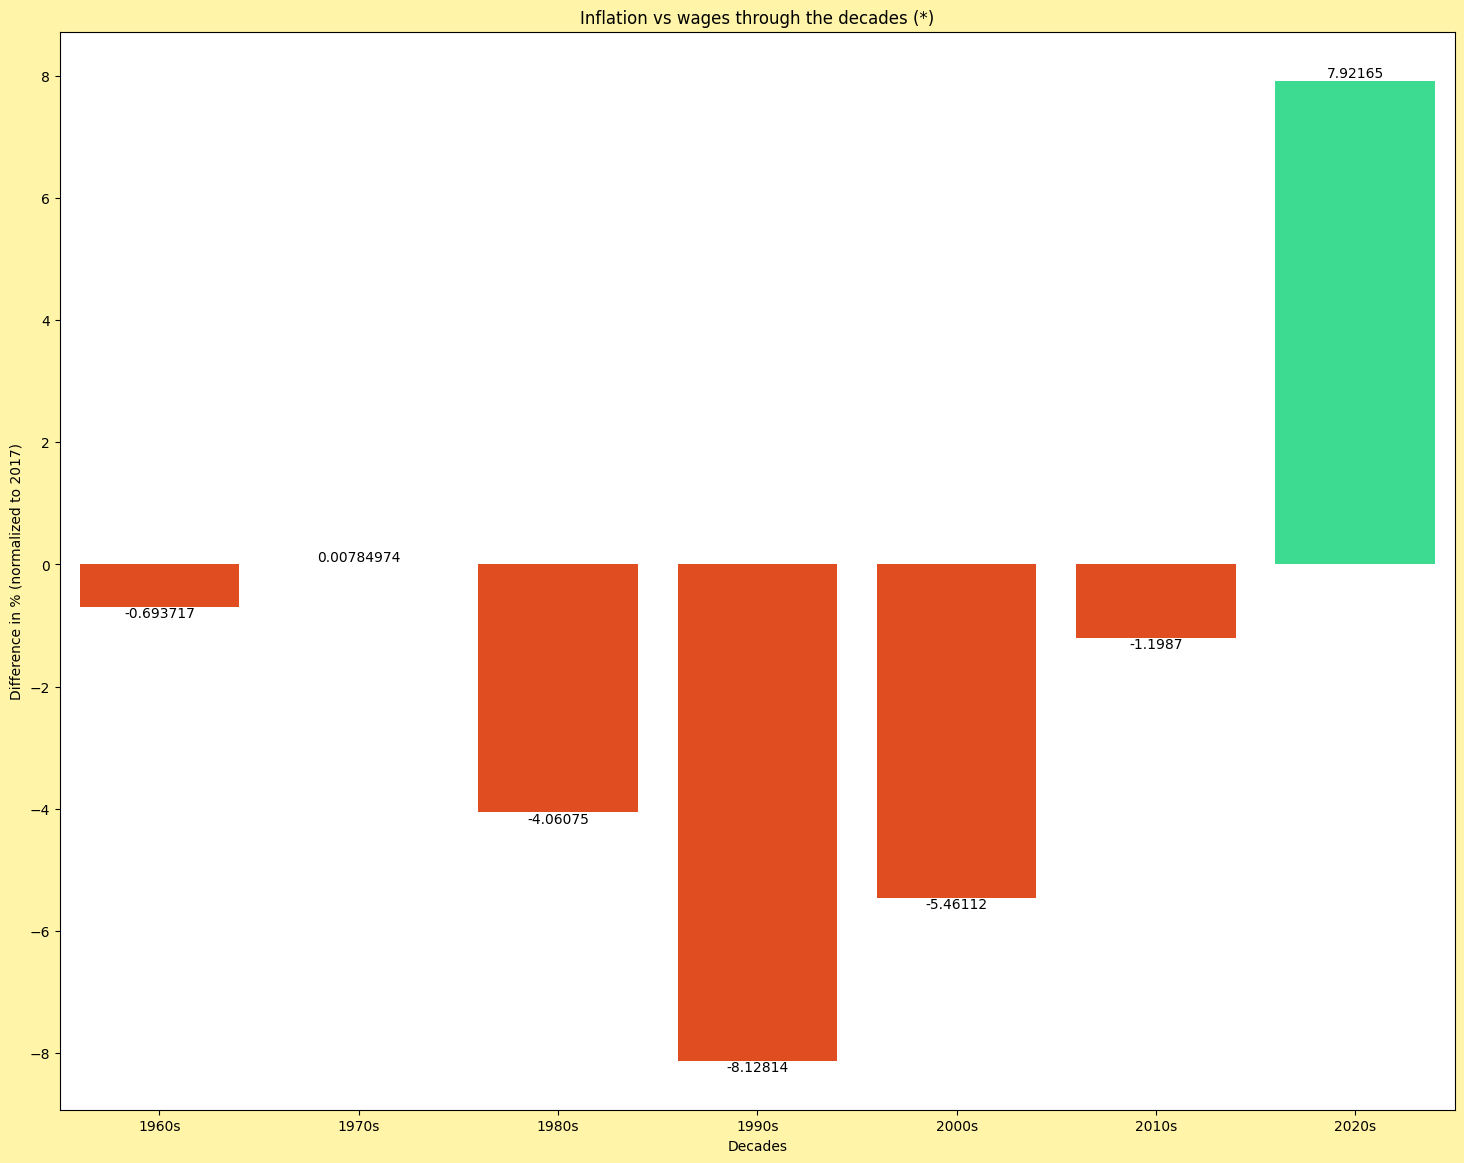

In [5]:
inflation_wages_df = df_all[df_all['variable'].isin(['CPIAUCSL', 'AHETPI'])].copy()
inflation_wages_df['decades'] = (inflation_wages_df['observation_date'].dt.year //10) * 10
inflation_wages_df['decades'] = inflation_wages_df['decades'].map({
    1960:'1960s', 1970:'1970s', 1980:'1980s', 1990:'1990s', 2000:'2000s',
    2010:'2010s', 2020:'2020s'
})
inflation_df = inflation_wages_df[inflation_wages_df['variable']=='CPIAUCSL'].copy()
aggregated_inflation = inflation_df.groupby('decades')['value'].mean().reset_index()
wages_df = inflation_wages_df[inflation_wages_df['variable']=='AHETPI'].copy()
wages_df['value'] = (wages_df['value'] / base_value.loc[base_value.index[0], 'value']) * 100
aggregated_wages = wages_df.groupby('decades')['value'].mean().reset_index()
merged = pd.merge(aggregated_wages, aggregated_inflation, on='decades', suffixes=('_wages','_inflation'))
merged['difference'] = merged['value_wages'] - merged['value_inflation']

colors = {row['decades']: ('#FF3C00' if row['difference'] < 0 else '#21F693') for _,row in merged.iterrows()}

plt.figure(figsize=(18,14), facecolor='#FFF4A8')
ax = sns.barplot(data=merged, x='decades', y='difference',hue='decades', palette=colors)
plt.title('Inflation vs wages through the decades (*)')
plt.ylabel('Difference in % (normalized to 2017)')
plt.xlabel('Decades')
for container in ax.containers:
    ax.bar_label(container)
plt.show()


## 6. Unemployment by Decade

#### This graph shows the unemployment rate through the decades with the biggest one being red and the lowest being green.


In [6]:
unrate_df = df_all[df_all['variable']=='UNRATE'].copy()
unrate_df['decades'] = (unrate_df['observation_date'].dt.year // 10) * 10
unrate_df['decades'] = unrate_df['decades'].map({
    1960:'1960s', 1970:'1970s', 1980:'1980s', 1990:'1990s', 2000:'2000s',
    2010:'2010s', 2020:'2020s'
})
agg = unrate_df.groupby('decades')['value'].mean().reset_index()
max_decade = agg.loc[agg['value'].idxmax(),'decades']
min_decade = agg.loc[agg['value'].idxmin(),'decades']
colors = {d:('#fa4a4a' if d==max_decade else '#00cc00' if d==min_decade else '#a18989') for d in agg['decades']}

plt.figure(figsize=(18,14), facecolor='#DBDB6B')
sns.barplot(data=agg, x='decades', y='value',hue='decades', palette=colors)
plt.title('Unemployment rate through decades')
plt.ylabel('% unemployment')
plt.xlabel('Decades')
plt.show()


## 7. Phillips Curve Analysis

#### This graph has unemployment rate as the x axis and inflation rate as the y axis, with decades being color coded it allows for an analysis of the phillips curve asssumption that unemployment and inflation have an inverse relationship. As we can notice this theory holds up for 1960s and the case could be made for 2000s and 2020s, but the variance in the curves throughout the decades shows that for this relationship to exist, it requires a specific environment. 


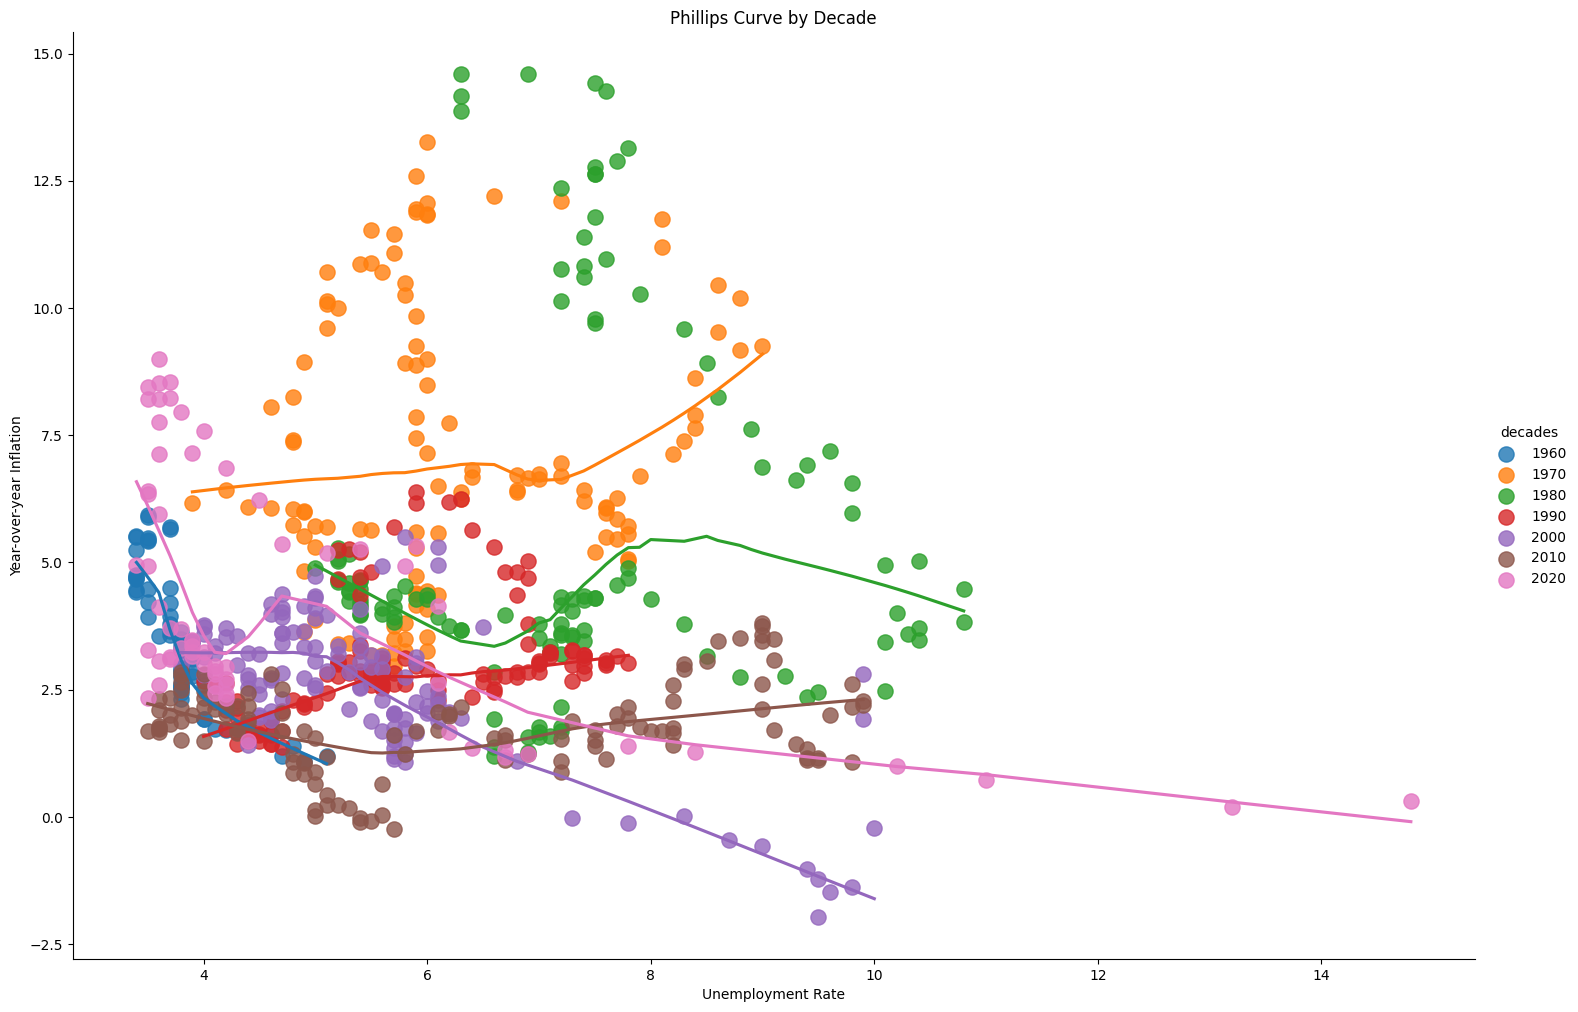

In [7]:
unrate_df = df_all[df_all['variable']=='UNRATE']
inflation_df = df_all[df_all['variable']=='CPIAUCSL']
base_value = 243.618

merged = pd.merge(unrate_df,inflation_df,on='observation_date',suffixes=('_unrate','_inflation'))
merged['unnormalized'] = (merged['value_inflation']/100)*base_value
merged['YoY_inflation'] = merged['unnormalized'].pct_change(periods=12)*100
merged['decades'] = (merged['observation_date'].dt.year//10)*10
merged = merged.dropna(subset=['YoY_inflation'])

sns.lmplot(data=merged, x='value_unrate', y='YoY_inflation', hue='decades', lowess=True,
           height=10, aspect=1.5, scatter_kws={'s':120})
plt.title('Phillips Curve by Decade')
plt.xlabel('Unemployment Rate')
plt.ylabel('Year-over-year Inflation')
plt.show()
